In [1]:
import os

os.chdir("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
# %#load_ext autoreload
# %#autoreload 2
# %#matplotlib inline

In [3]:
import itertools
import numpy as np
import tqdm

from modular_splicing.gtex_data.experiments.create_dataset import MarginalPsiV2
from modular_splicing.gtex_data.experiments.tissue_groups import main_tissue_groups_v1

from modular_splicing.dataset.basic_dataset import basic_dataset
from modular_splicing.dataset.multi_tissue_h5_dataset import (
    MultiTissueProbabilitiesH5Dataset,
)

from modular_splicing.utils.plots.plot_psam import render_psams

INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face.  Unknown file format.


In [4]:
def splicepoint_sequence_logo(data, splice, cl=9, eye=False):
    xs = np.array([d["inputs"]["x"] for d in data])
    ys = np.array([d["outputs"]["y"] for d in data])
    if eye:
        ys = np.eye(3)[ys]
    batch_idxs, seq_idxs = np.where(ys[:, :, splice] > 0.5)
    batch_idxs = batch_idxs[:, None].repeat(cl, 1)
    seq_idxs = seq_idxs[:, None] + np.arange(-(cl // 2), cl // 2 + 1)
    return xs[batch_idxs, seq_idxs + (xs.shape[1] - ys.shape[1]) // 2].mean(0)


def render_data(data, **kwargs):
    render_psams(
        [splicepoint_sequence_logo(data, c, **kwargs) for c in (1, 2)],
        names=["3'", "5'"],
    )

In [6]:
dset = MultiTissueProbabilitiesH5Dataset(
    path=f"{MarginalPsiV2.data_path_folder}dataset_train_all.h5",
    sl=5000,
    cl=400,
    cl_max=10_000,
    iterator_spec=dict(type="FastIter", shuffler_spec=dict(type="DoNotShuffle")),
    post_processor_spec=dict(type="IdentityPostProcessor"),
    datapoint_extractor_spec=dict(
        type="MultipleSettingDatapointExtractor", run_argmax=False
    ),
    tissue_groups=main_tissue_groups_v1,
)
dset_original = basic_dataset(
    "dataset_test_0.h5",
    400,
    10_000,
    sl=5000,
    post_processor_spec=dict(type="IdentityPostProcessor"),
)

In [7]:
amount = 10_000
data = list(tqdm.tqdm(itertools.islice(dset, amount), total=amount))
data_original = list(tqdm.tqdm(itertools.islice(dset_original, amount), total=amount))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1166.50it/s]


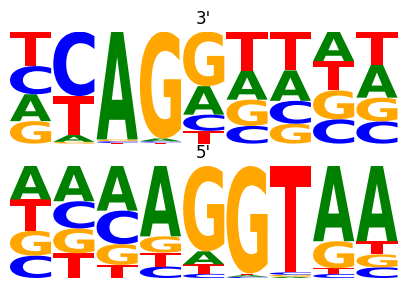

In [8]:
render_data(data)

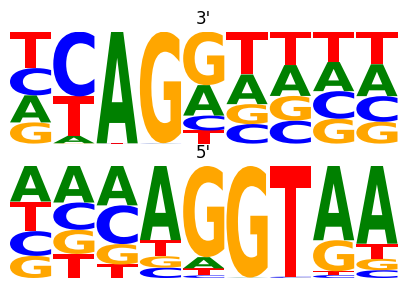

In [9]:
render_data(data_original, eye=True)